In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.fft import fft
from scipy import signal as signal

In [2]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = signal.get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = signal.get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

def plot_freq_response(w, h, title):
  "Utility function to plot frequency response functions"
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  ax.plot(w, 20*np.log10(np.abs(h)))
  ax.set_ylim(-80, 5)
  ax.grid(True)
  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Gain (dB)')
  ax.set_title(title)

def prototype_filter(N, L):
  """ Generate a prototype FIR low-pass filter using a window method.
    Args:
      N (int): length of filter
      L (int): number of subbands
    Returns:
      Coefficients of the resulting FIR filter
  """
  return signal.firwin(N, 1.0 / (2 * L), window='hamming')

def modulate_filter(h, M, k):
    # Modulate the prototype filter
    n = np.arange(len(h))
    modulation = 2 * np.cos(np.pi * (2 * k + 1) * (n - (len(h) - 1) / 2) / (2 * M))
    return h * modulation

def analysis_filter_bank(x, M, N):
    # Analysis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    subband_length = len(x) // M
    subbands = np.zeros((M, subband_length))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        filtered_signal = signal.lfilter(hk, 1.0, x)
        # Ensure the subband length matches the expected size
        downsampled_signal = filtered_signal[::M]
        if len(downsampled_signal) > subband_length:
            subbands[k] = downsampled_signal[:subband_length]
        else:
            subbands[k, :len(downsampled_signal)] = downsampled_signal

    return subbands

def synthesis_filter_bank(subbands, M, N):
    # Synthesis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    y_reconstructed = np.zeros(M * len(subbands[0]))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        upsampled_signal = np.zeros(len(y_reconstructed))
        upsampled_signal[::M] = subbands[k]  # Upsample by M
        y_reconstructed += signal.lfilter(hk, 1.0, upsampled_signal)

    return y_reconstructed

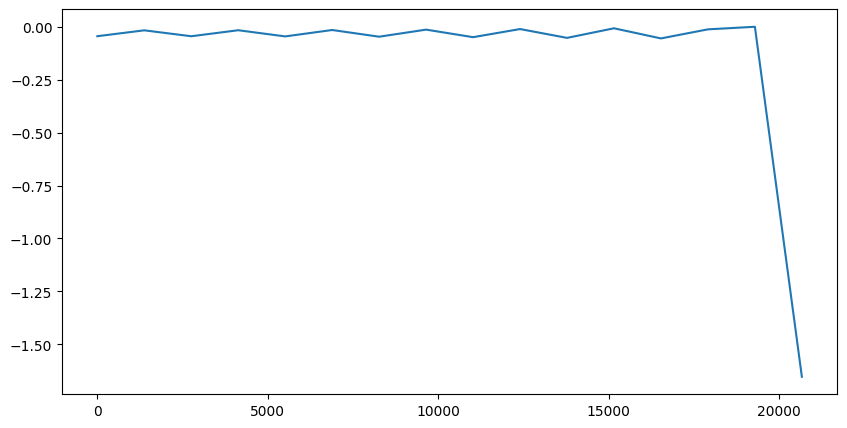

In [3]:
# add all the bandpass filters

# Parameters for the filter bank
N = 32  # Length of the prototype filter
L = 4   # Number of subbands
fs = 44100  # Sampling rate

h = prototype_filter(N, L)
ht = h
ms = np.zeros(N, dtype=np.complex128)
for k in range(L):
  hk = modulate_filter(h, L, k)
  spectrum = fft(hk)
  ms += spectrum

magnitude_spectrum = 20*np.log10(abs(ms[:ms.size//2]))

plt.figure(0, figsize=(10, 5))
frequency_indexes = np.arange(0, fs/2, fs/spectrum.size)
plt.plot(frequency_indexes, magnitude_spectrum)
plt.show()

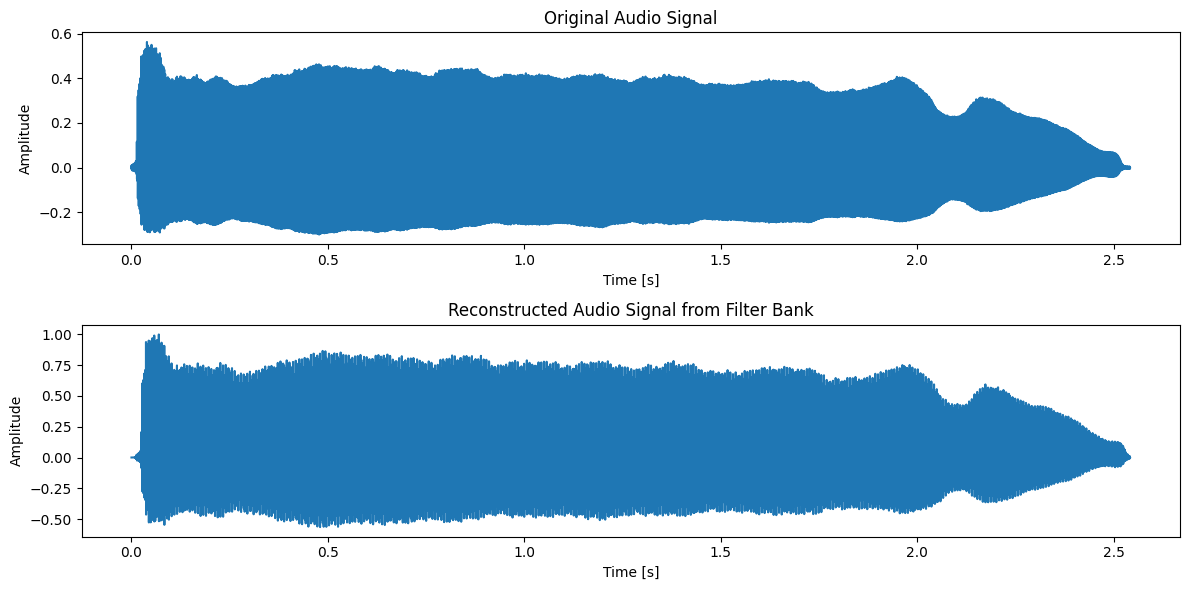

In [4]:
# Parameters for the filter bank
N = 512  # Length of the prototype filter
L = 32   # Number of subbands
fs = 44100  # Sampling rate

sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')
# rounded_size = (sound_array.size//L)*L
# sound = sound_array[:rounded_size]
t = np.linspace(0, len(sound_array)/sampling_rate, len(sound_array), endpoint=False)

# Analysis (Filter the signal into subbands and downsample)
subbands = analysis_filter_bank(sound_array, L, N)

# Synthesis (Upsample the subbands and reconstruct the signal)
y_reconstructed = synthesis_filter_bank(subbands, L, N)

# Optional: Normalize the output signal
y_reconstructed = y_reconstructed / np.max(np.abs(y_reconstructed))

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sound_array)
plt.title("Original Audio Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

plt.subplot(2, 1, 2)
plt.plot(t[:len(y_reconstructed)],y_reconstructed)
plt.title("Reconstructed Audio Signal from Filter Bank")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=y_reconstructed, rate=sampling_rate))

plt.tight_layout()
plt.show()
